# Dynamics HW

See [this talk by Scott Tremaine](https://youtu.be/kLRbfszj6DM?list=PLTn74Qx5mPsSZsGO1AN6wfDlz7cmeTrtj&t=2844)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
%run ~/.jupyter/config.ipy
mpl.rcParams["figure.dpi"] = 300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Earth-Sun with Euler method

We have 4 equations (because motion is in a plane):

$$
\dot{r_{i}} = v_{i}
$$
$$
\dot{v_{i}} = - \Sigma \frac{G m_{j}}{r_{ij}^{3}} (r_{i} - r_{j})
$$

In [55]:
year = 2*np.pi
day = year/365
end = 2*np.pi

In [70]:
class integrator():
    obj_dtype = [("mass", np.float64), 
                 ("x", np.float64), ("y", np.float64), 
                 ("vx", np.float64), ("vy", np.float64)]
    G = 1 # We use the same units as rebound - G = 1, distance in AU, mass in Msun, time in yr/(2*pi)
    
    def __init__(self):
        self.objs = np.zeros(0, dtype=self.obj_dtype)
    
    def add_obj(self, initial_params):
        self.objs = np.append(self.objs, np.array(initial_params, dtype=self.obj_dtype))
        
    def euler_integrate(self, total_dt, step_dt):
        print("Starting from {}".format(self.objs))
        steps = int(total_dt / step_dt)
        results = np.zeros((steps + 1, len(self.objs)), dtype=self.obj_dtype)
        results[0,:] = self.objs
        
        for i in range(steps):
            accs = self._get_acc(results[i,:])
            results[i+1,:] = results[i,:]
            
            results[i+1,:]["x"] += results[i+1,:]["vx"] * step_dt
            results[i+1,:]["y"] += results[i+1,:]["vy"] * step_dt
            
            results[i+1:,]["vx"] += accs["x"] * step_dt
            results[i+1:,]["vy"] += accs["y"] * step_dt    
        return results
    
    def modified_euler_integrate(self, total_dt, step_dt):
        """
        Same as Euler except we first advance the position, then the velocity based on the acc at the new position
        """
        print("Starting from {}".format(self.objs))
        steps = int(total_dt / step_dt)
        results = np.zeros((steps + 1, len(self.objs)), dtype=self.obj_dtype)
        results[0,:] = self.objs
        
        for i in range(steps):
            results[i+1,:] = results[i,:]
            
            results[i+1,:]["x"] += results[i+1,:]["vx"] * step_dt
            results[i+1,:]["y"] += results[i+1,:]["vy"] * step_dt
            
            accs = self._get_acc(results[i+1,:])
            
            results[i+1:,]["vx"] += accs["x"] * step_dt
            results[i+1:,]["vy"] += accs["y"] * step_dt    
        return results
    
    def leapfrog_integrate(self, total_dt, step_dt):
        """
        Summarized as kick-drift-kick. 
        1) Update V by half a timestep (using acc at the initial pos)
        2) Use that V to drift for full timestep
        3) Update V by the second half timestep (using acc at the ending pos)
        """
        print("Starting from {}".format(self.objs))
        steps = int(total_dt / step_dt)
        results = np.zeros((steps + 1, len(self.objs)), dtype=self.obj_dtype)
        results[0,:] = self.objs
        
        for i in range(steps):
            results[i+1,:] = results[i,:]
            
            # Kick
            accs = self._get_acc(results[i+1,:])
            results[i+1:,]["vx"] += accs["x"] * step_dt/2
            results[i+1:,]["vy"] += accs["y"] * step_dt/2
            
            # Drift
            results[i+1,:]["x"] += results[i+1,:]["vx"] * step_dt
            results[i+1,:]["y"] += results[i+1,:]["vy"] * step_dt
            
            # Kick
            accs = self._get_acc(results[i+1,:])
            results[i+1:,]["vx"] += accs["x"] * step_dt/2
            results[i+1:,]["vy"] += accs["y"] * step_dt/2
        return results
    
    def runge_kutta_4_integrate(self, total_dt, step_dt):
        """
        See http://spiff.rit.edu/richmond/nbody/OrbitRungeKutta4.pdf
        I think there might be a bug in this because it is pretty bad...

        * kv1 - acc(x_i)
        * kr1 - v_i
        
        * kv2 - acc(x_i + kr1 * dt / 2) - the a with the estimated midpoint.
        * kr2 - v_i + kv1 * dt / 2 - the vel with the estimated midpoint
        
        * kv3 - acc(x_i + kr2 * dt / 2) - same as 2 but with a different midpoint
        * kr3 - v_i + kv2 * dt/ 2
        
        * kv4 - acc(x_i + kr3 * dt) - the a at the expected endpoint
        * kr4 - v_i + kv3 * dt
        
        Then to get the final positions:
        v_(i+1) = v_i * (kv1 + 2*kv2 + 3*kv3 + kv4) * dt / 6
        """
        print("Starting from {}".format(self.objs))
        steps = int(total_dt / step_dt)
        results = np.zeros((steps + 1, len(self.objs)), dtype=self.obj_dtype)
        results[0,:] = self.objs
        
        for i in range(steps):
            results[i+1,:] = results[i,:]
            
            kv1 = self._rv(self._get_acc(results[i+1,:]))
            kr1 = self._rv(results[i+1,:][["vx", "vy"]])
            
            kv2 = self._rv(self._get_acc(
                self._rv2(results[i+1,:], kr1 * step_dt / 2 # estimated midpoint position
            )))
            kr2 = self._rv(results[i+1,:][["vx", "vy"]]) + kv1 * step_dt / 2
            
            kv3 = self._rv(self._get_acc(
                self._rv2(results[i+1,:], kr2 * step_dt / 2 # estimated midpoint position
            )))
            kr3 = self._rv(results[i+1,:][["vx", "vy"]]) + kv2 * step_dt / 2
            
            kv4 = self._rv(self._get_acc(
                self._rv2(results[i+1,:], kr3 * step_dt
            )))
            kr4 = self._rv(results[i+1,:][["vx", "vy"]]) + kv3 * step_dt
            
            
            v_delta = (kv1 + 2*kv2 + 3*kv3 + kv4) * step_dt / 6
            r_delta = (kr1 + 2*kr2 + 3*kr3 + kr4) * step_dt / 6
            # Kick
            
            results[i+1:,]["vx"] += v_delta[:,0]
            results[i+1:,]["vy"] += v_delta[:,1]
            
            # Drift
            results[i+1,:]["x"] += r_delta[:,0]
            results[i+1,:]["y"] += r_delta[:,1]
        return results
    
        
    def _get_acc(self, objs):
        accs = np.zeros(len(objs), dtype=[("x", np.float64), ("y", np.float64)])
        for i in range(len(objs)):
            other_objs = objs[np.arange(len(objs)) != i]
            dx = other_objs["x"] - objs[i]["x"]
            dy = other_objs["y"] - objs[i]["y"]
            dists = np.sqrt(np.power(dx, 2) + np.power(dy, 2))
            acc = self.G * other_objs["mass"] / dists**3
            blah = np.sum(acc * (dx, dy), axis=1)
            accs[i]["x"] = blah[0]
            accs[i]["y"] = blah[1]
        return accs

    def _rv(self, arr):
        return arr.ravel().view(np.float64).reshape((-1, 2))
    
    def _rv2(self, res, delta_x):
        tmp = res.copy().ravel().view(np.float64).reshape((-1, 5))
        tmp[:,1:3] += delta_x
        return tmp.view(self.obj_dtype)

## Euler's method

Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]
Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]
Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]
Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]
Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]


No handles with labels found to put in legend.


[Text(0, 0.5, 'Fractional error'), Text(0.5, 0, 'theta')]

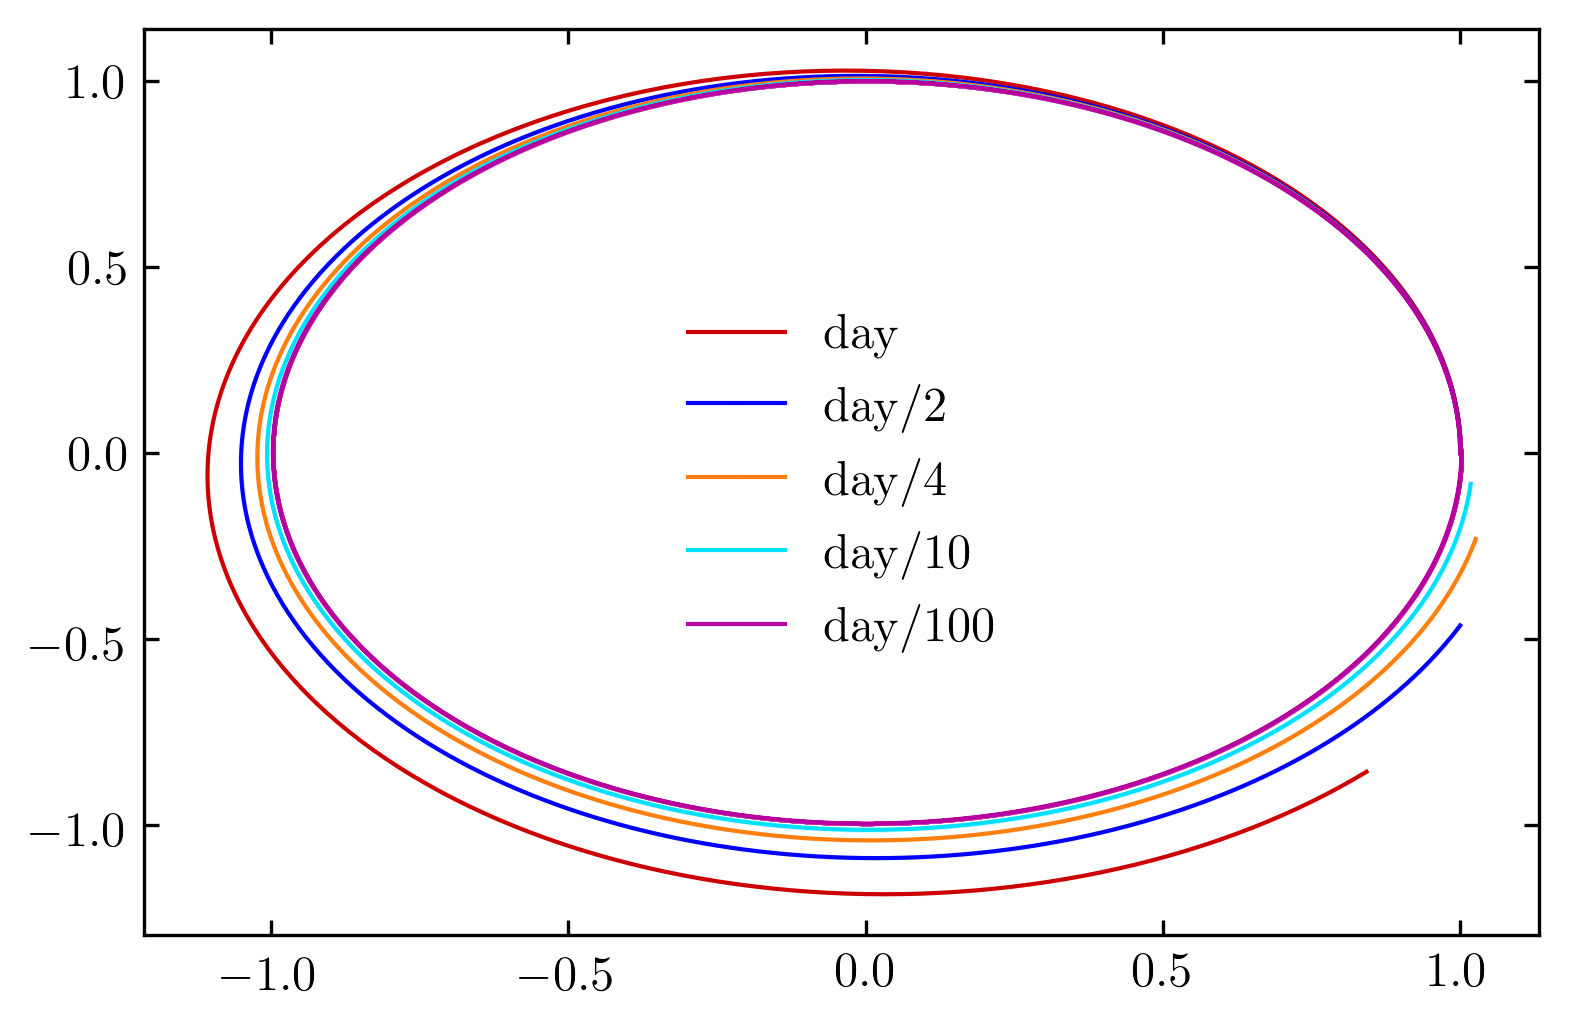

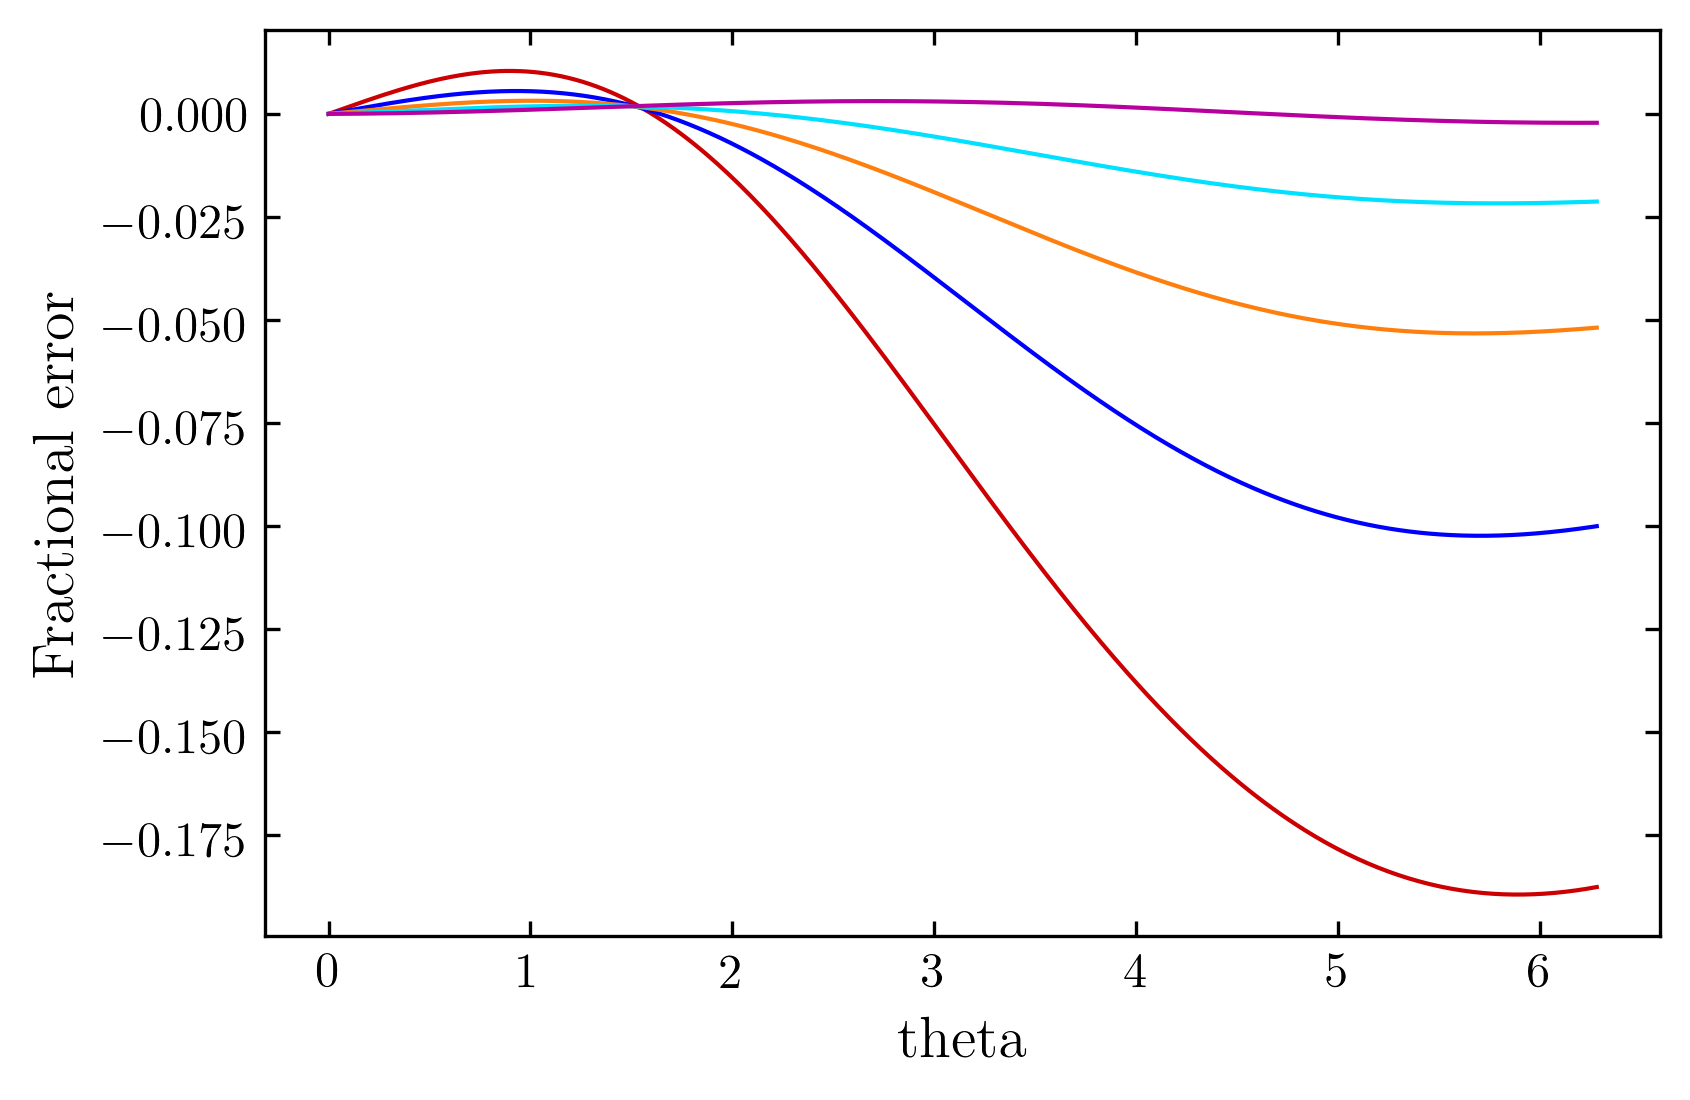

In [36]:
sim = integrator()
sim.add_obj((1, 0, 0, 0, 0))
sim.add_obj((1e-3, 1, 0, 0, 1))

_, ax = plt.subplots()
_, ax2 = plt.subplots()

for (step, lab) in [(day, "day"), (day/2, "day/2"), (day/4, "day/4"), (day/10, "day/10"), (day/100, "day/100")]:
    results = sim.euler_integrate(end, step)
    ax.plot(results[:,1]["x"], results[:,1]["y"], marker=".", markersize=0.02, label=lab)
    
    energy = np.sum(0.5 * results["mass"] * (results["vx"]**2 + results["vy"]**2), axis=1)
    ax2.plot(np.linspace(0, end, len(energy)), (energy - energy[0]) / energy[0])
ax.legend()
ax2.legend()
ax2.set(ylabel="Fractional error", xlabel="theta")

It looks like with a stepsize of a hundredth of a day we get a closed orbit. However, this might go wrong over multiple orbits.

Let's do exactly the same but with modified Euler.

## Modified Euler's method

Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]
Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]
Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]
Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]
Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]


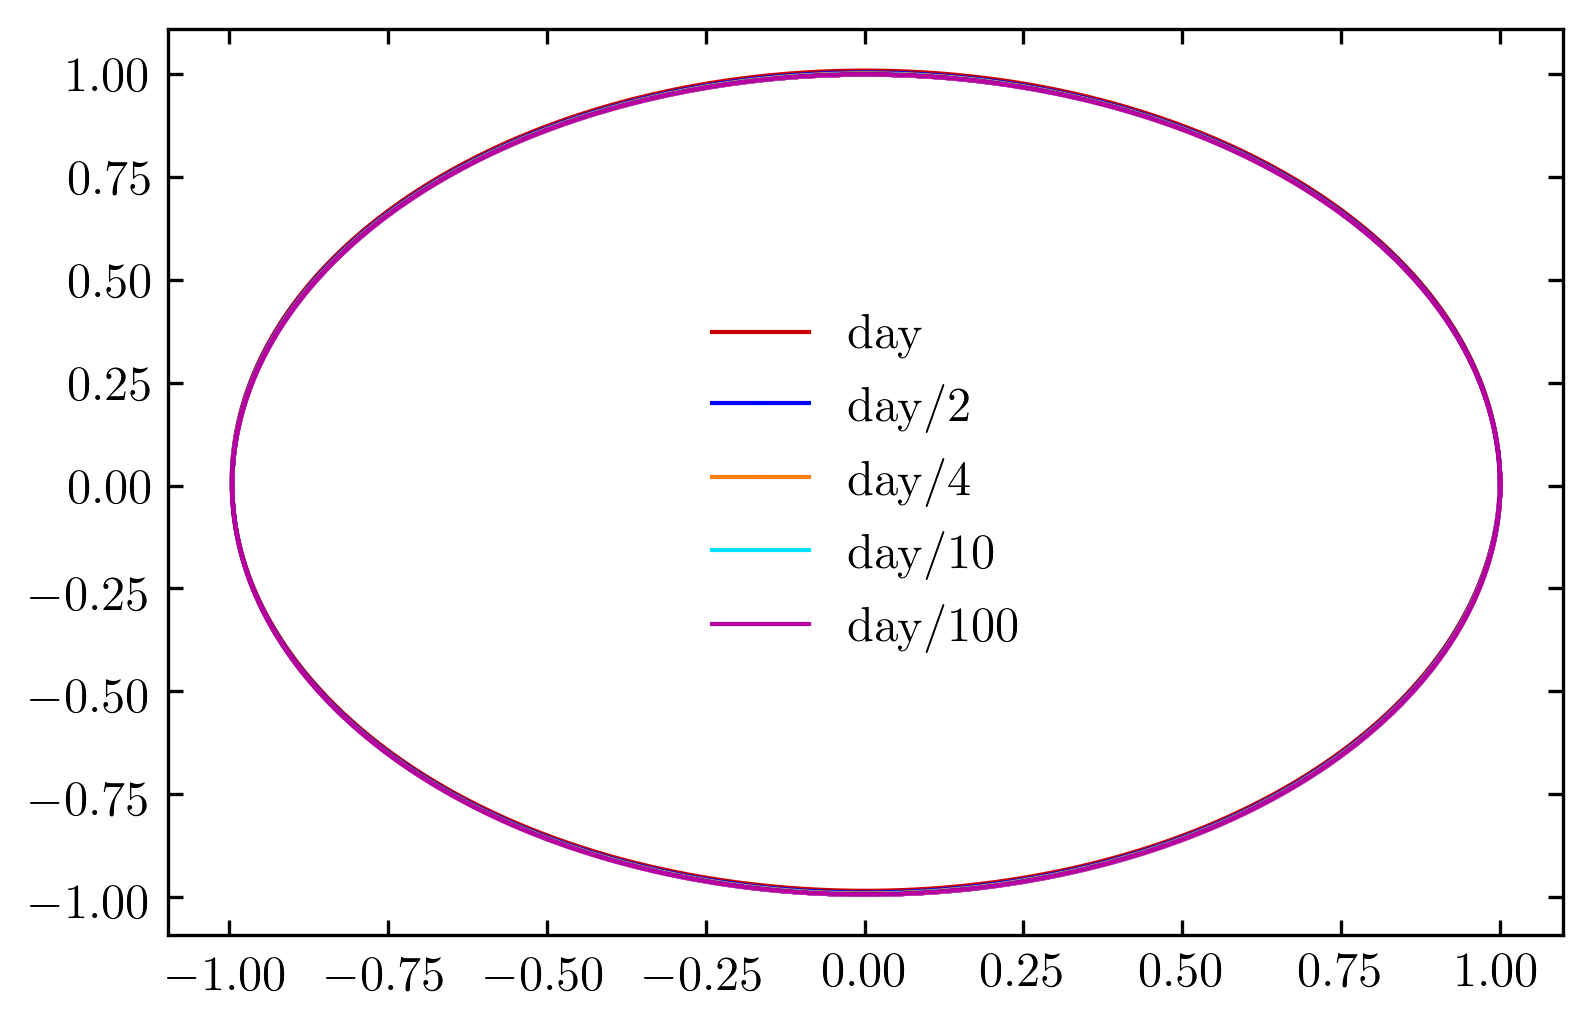

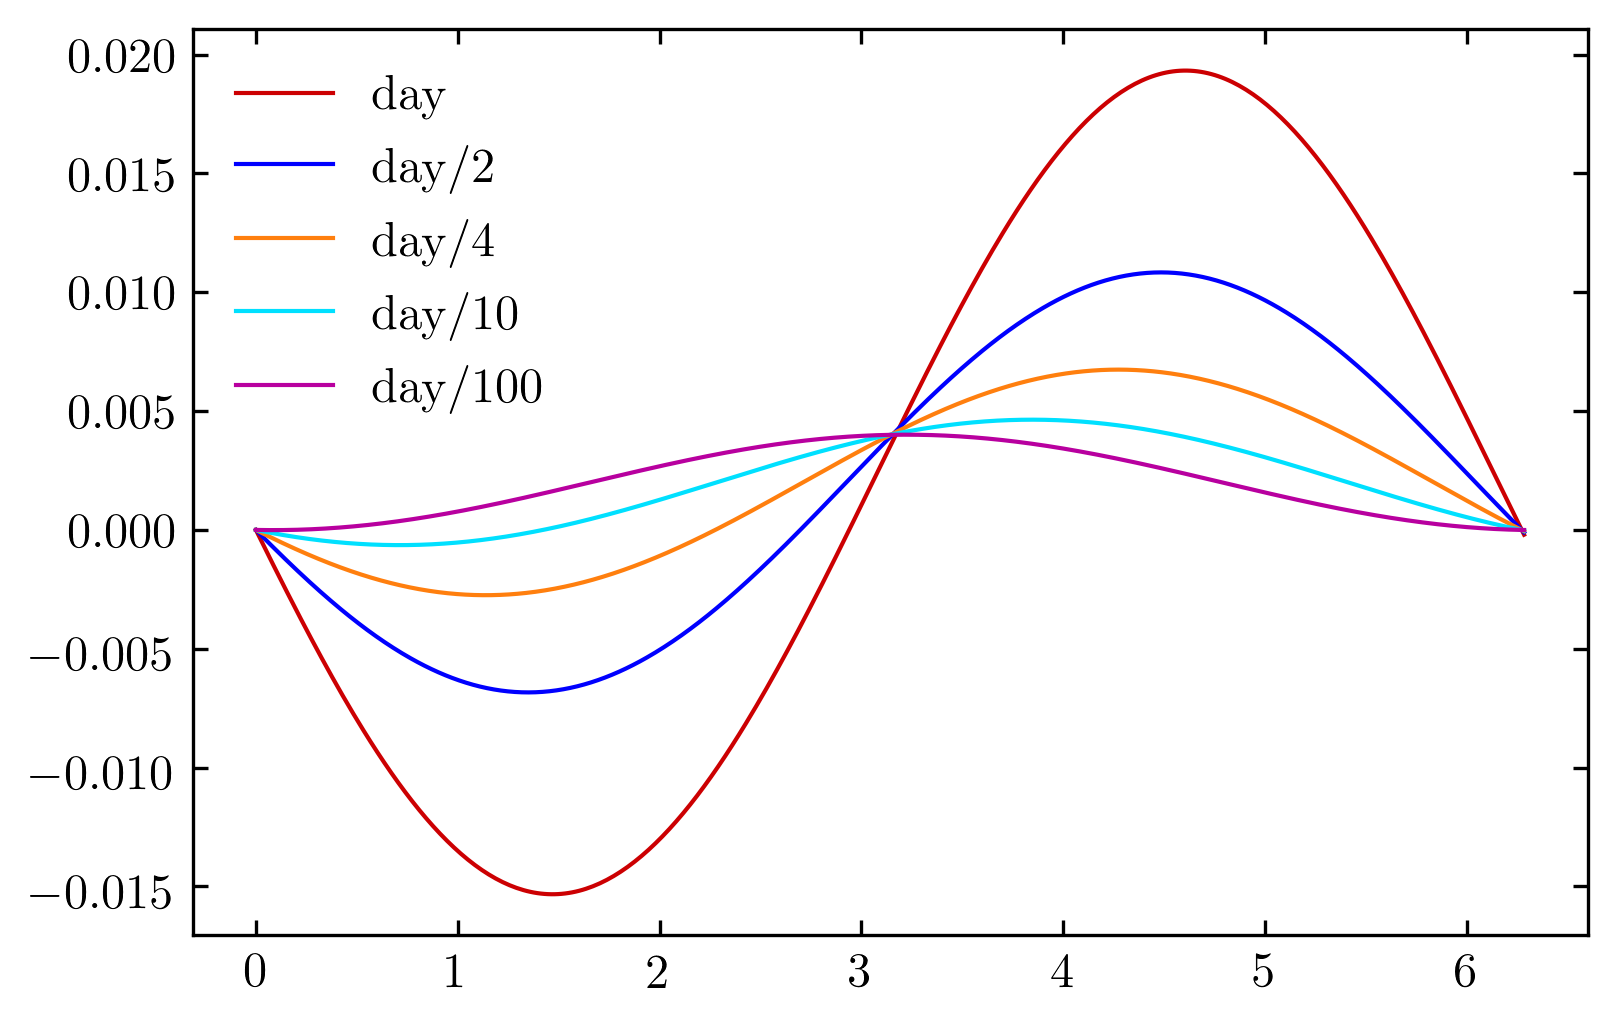

In [39]:
sim = integrator()
sim.add_obj((1, 0, 0, 0, 0))
sim.add_obj((1e-3, 1, 0, 0, 1))

end = 2*np.pi

_, ax = plt.subplots()
_, ax2 = plt.subplots()

for (step, lab) in [(day, "day"), (day/2, "day/2"), (day/4, "day/4"), (day/10, "day/10"), (day/100, "day/100")]:
    results = sim.modified_euler_integrate(end, step)
    ax.plot(results[:,1]["x"], results[:,1]["y"], marker=".", markersize=0.02, label=lab)
    
    energy = np.sum(0.5 * results["mass"] * (results["vx"]**2 + results["vy"]**2), axis=1)
    ax2.plot(np.linspace(0, end, len(energy)), (energy - energy[0]) / energy[0], label=lab)
ax.legend()
ax2.legend()

This is miles better! Let's see how it holds up over many orbits.

Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]
Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]


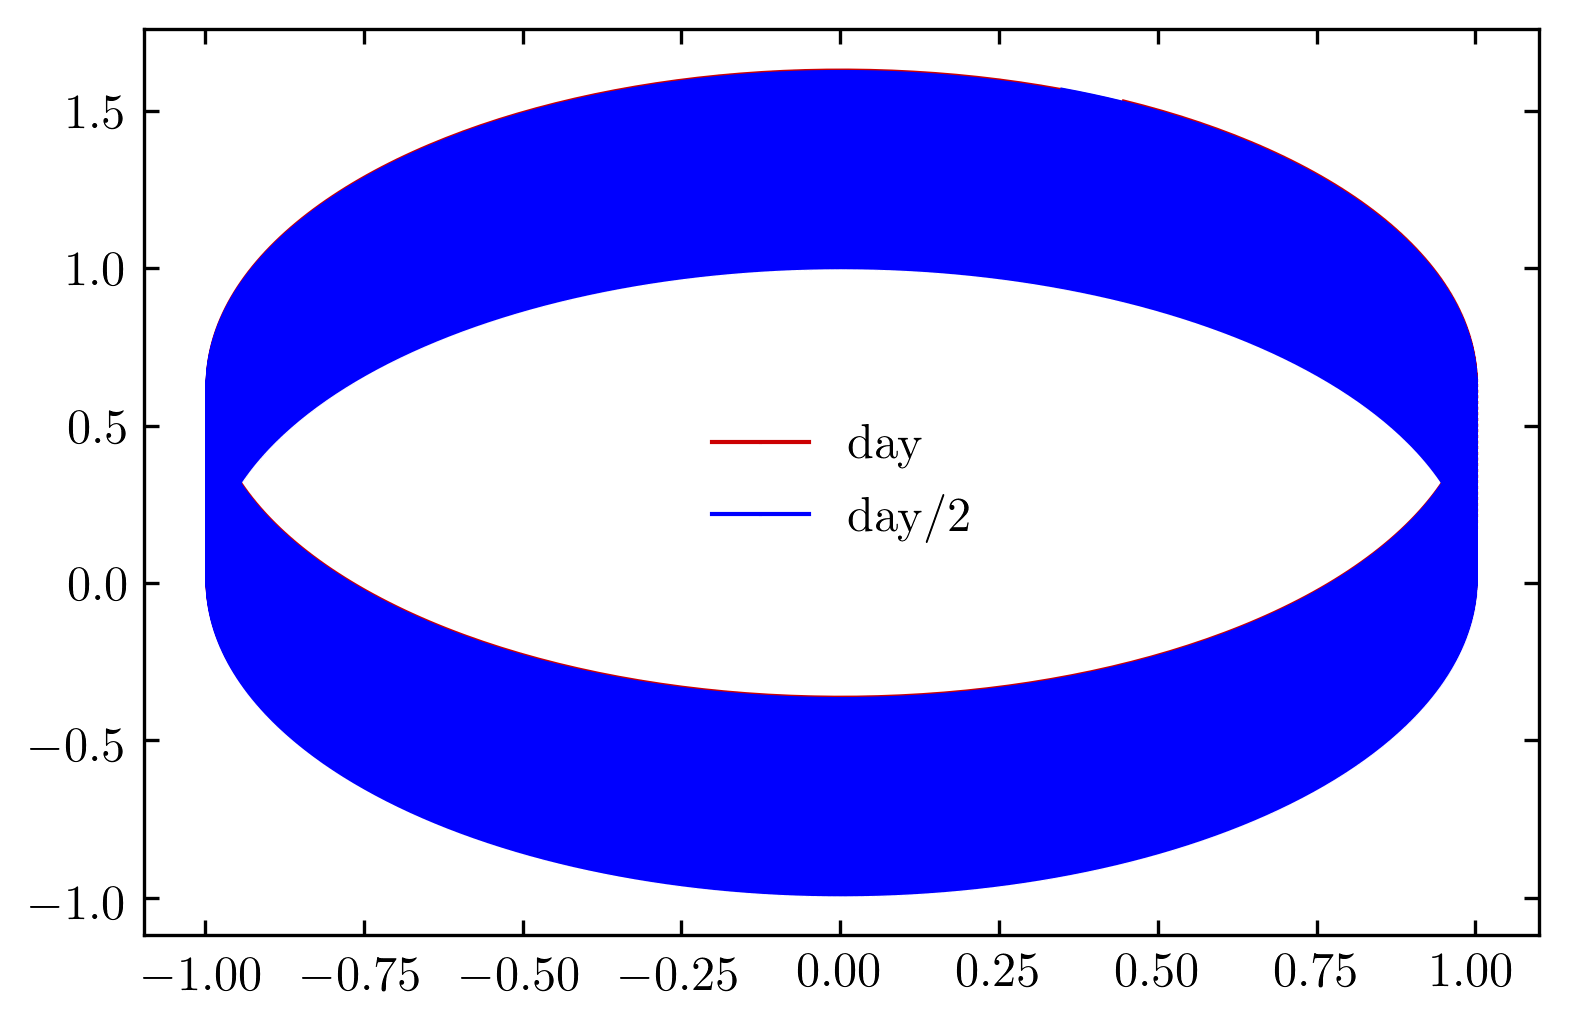

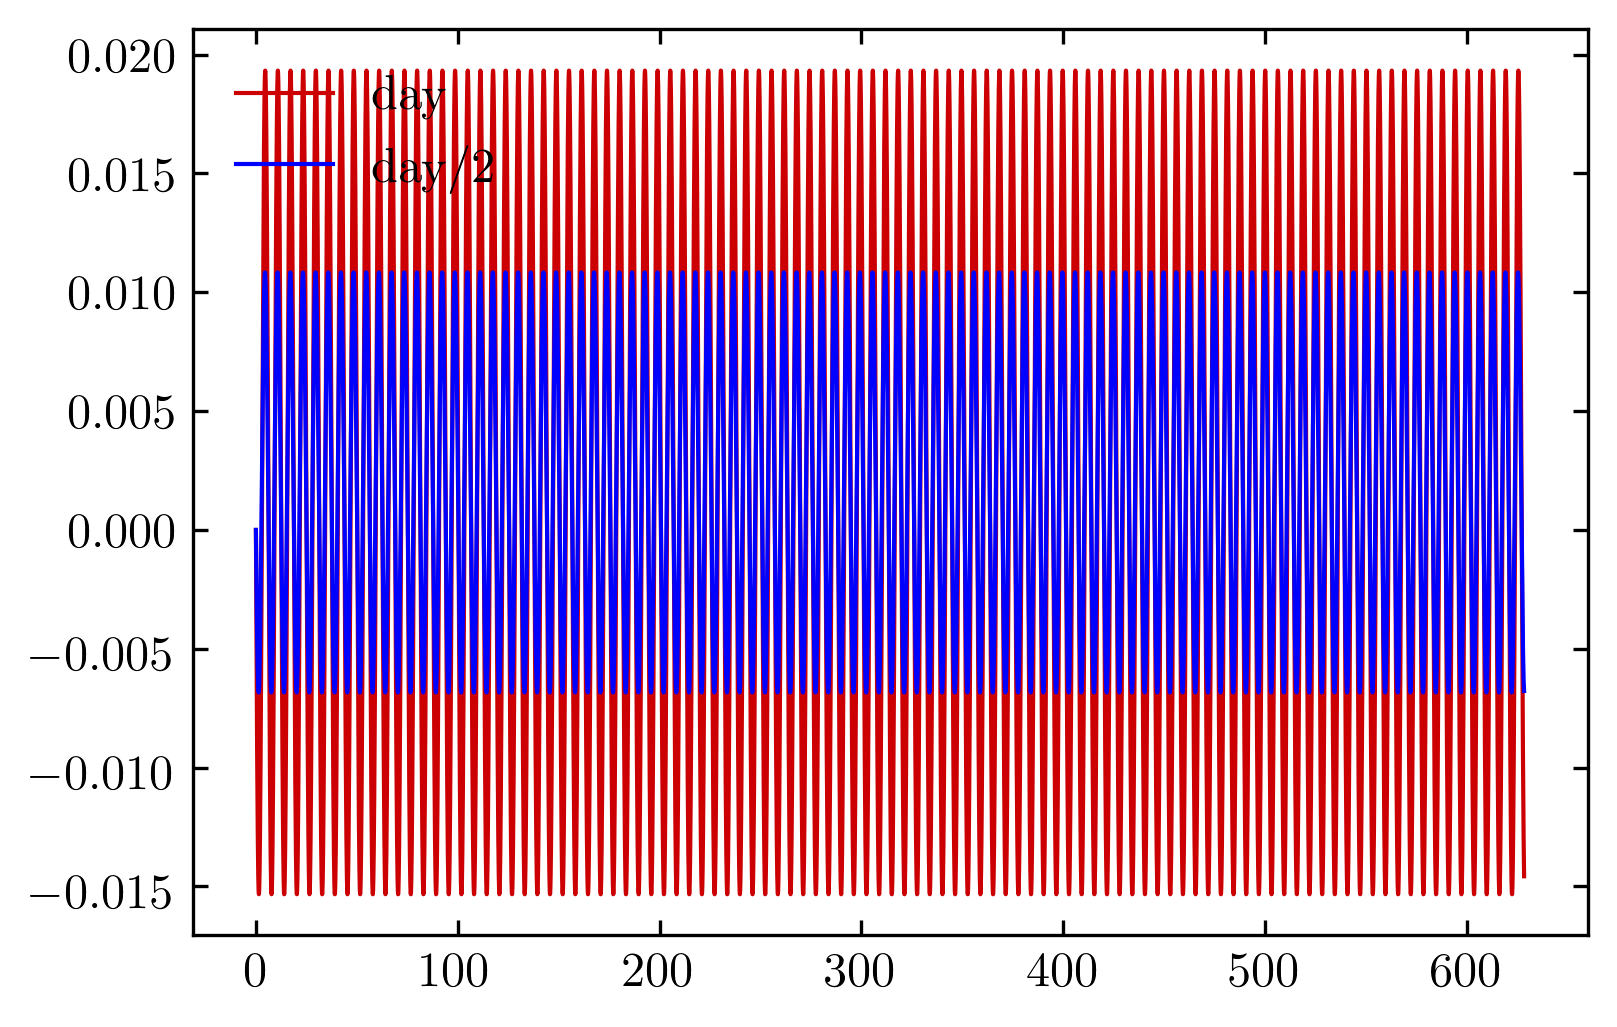

In [40]:
end = 2*np.pi * 100

_, ax = plt.subplots()
_, ax2 = plt.subplots()

for (step, lab) in [(day * 2, "day*2"), (day, "day")]:
    results = sim.modified_euler_integrate(end, step)
    ax.plot(results[:,1]["x"], results[:,1]["y"], marker=".", markersize=0.02, label=lab)
    
    energy = np.sum(0.5 * results["mass"] * (results["vx"]**2 + results["vy"]**2), axis=1)
    ax2.plot(np.linspace(0, end, len(energy)), (energy - energy[0]) / energy[0], label=lab)
    
    
ax.legend()
ax2.legend()

It looks like errors are bounded (unlike forward Euler where they quickly explode).

## Leapfrog

Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]
Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]


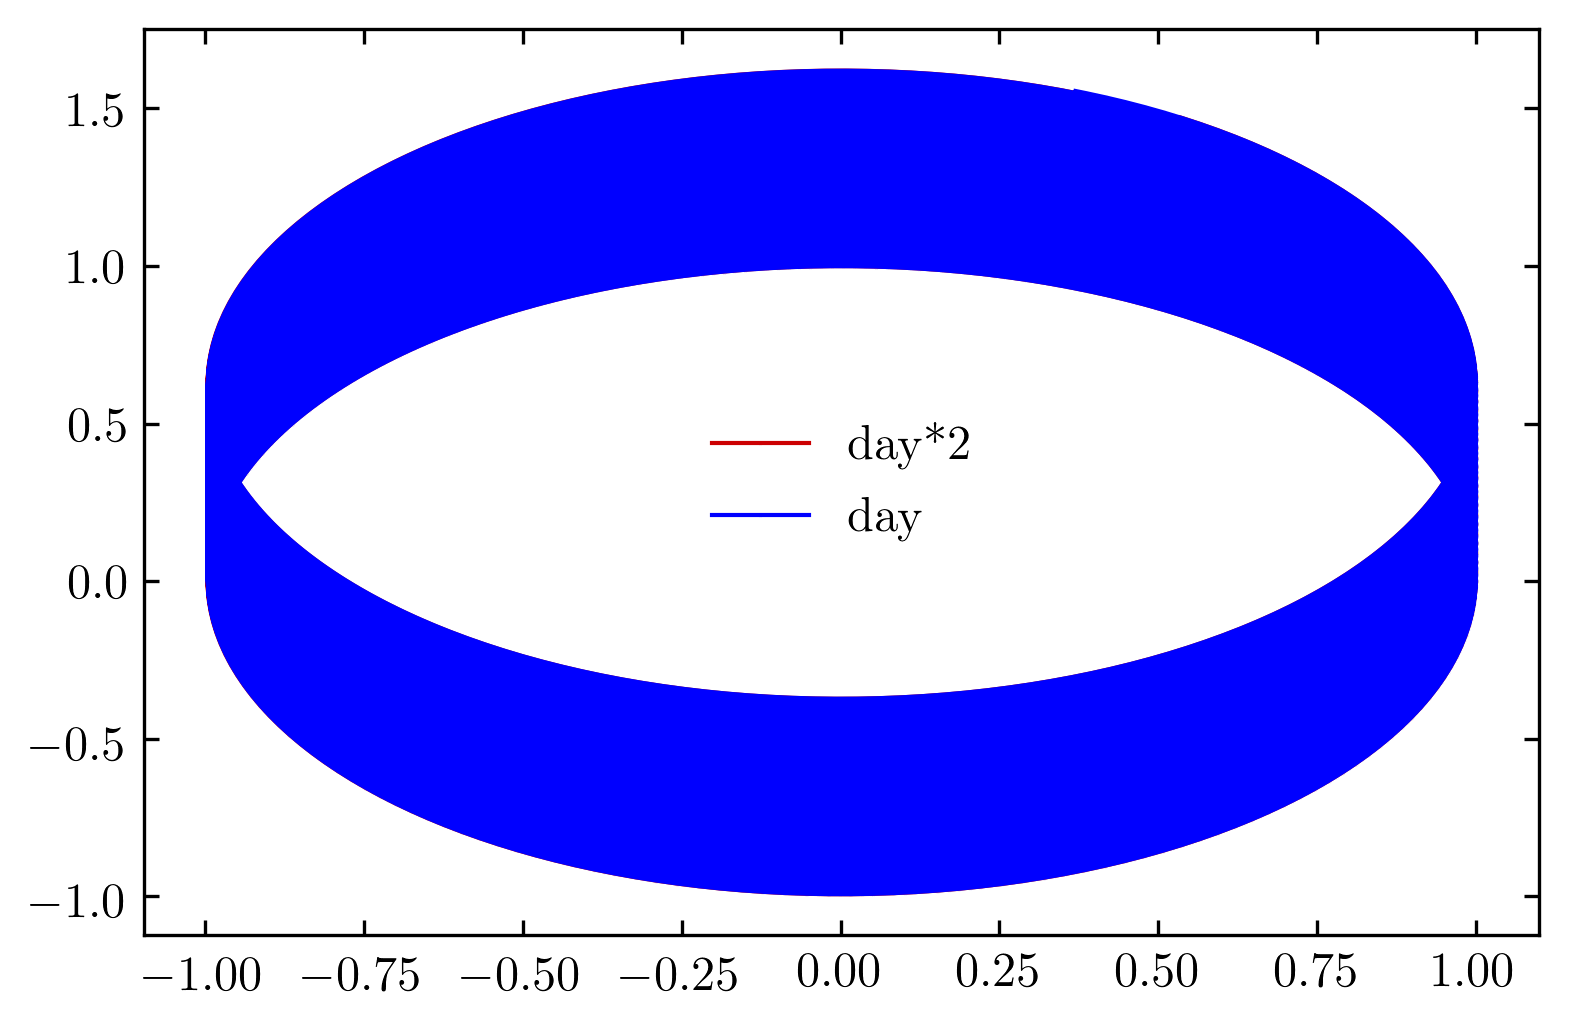

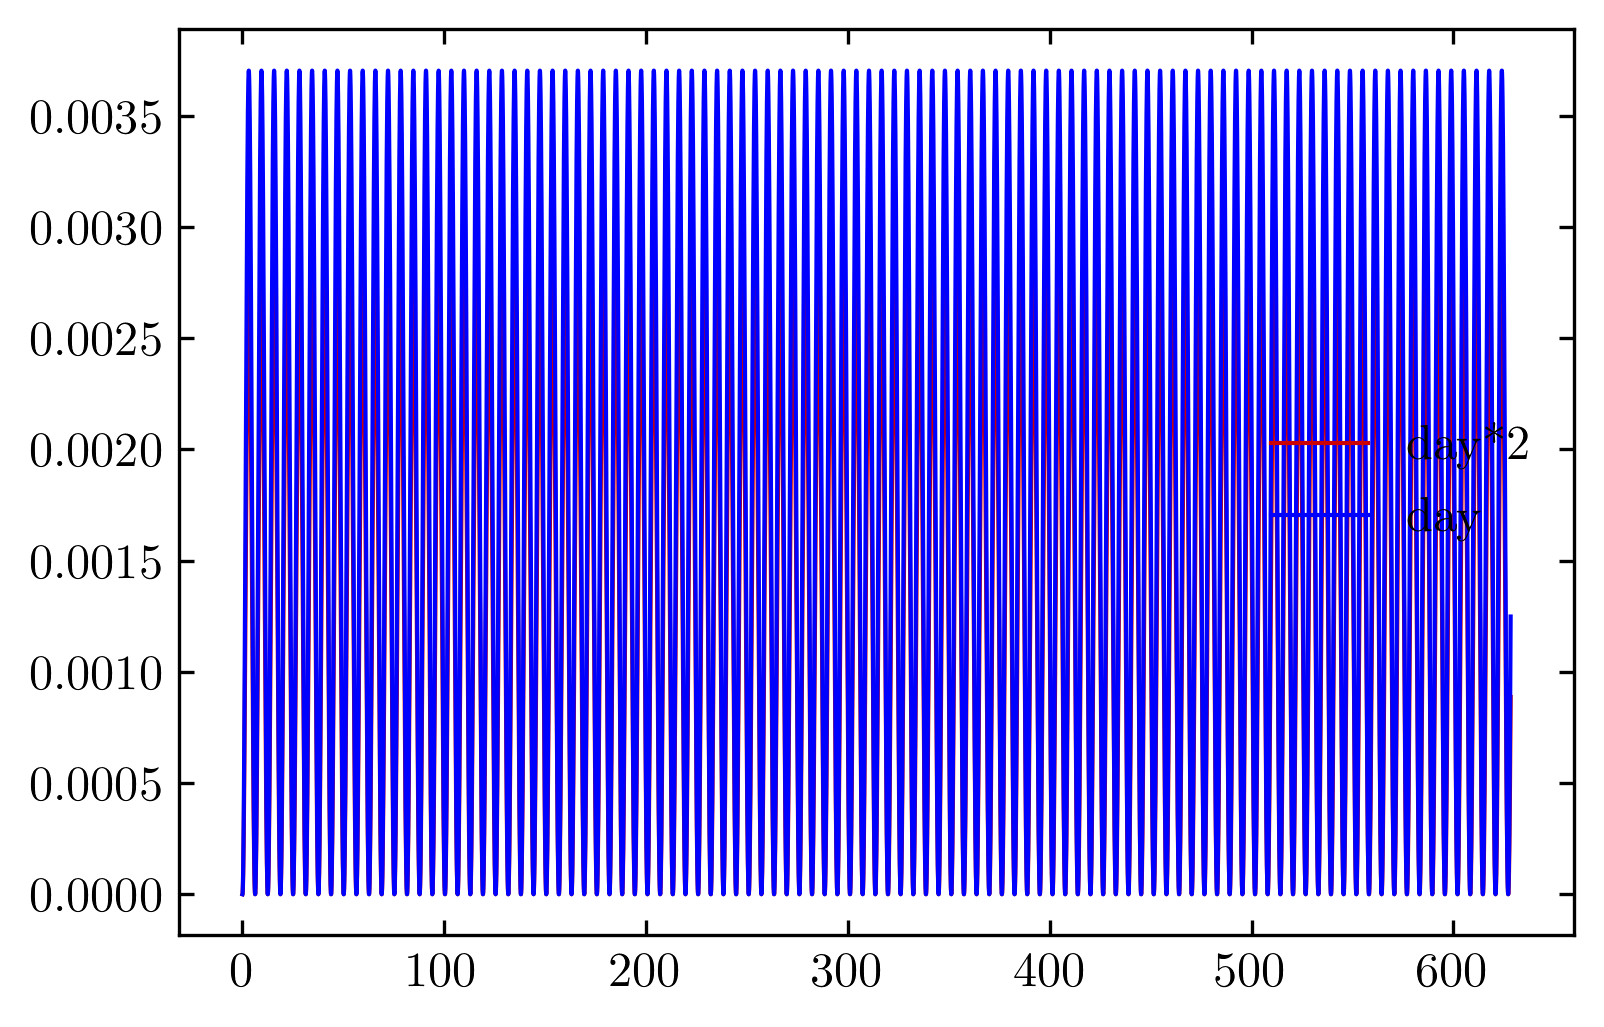

In [42]:
sim = integrator()
sim.add_obj((1, 0, 0, 0, 0))
sim.add_obj((1e-3, 1, 0, 0, 1))

end = 2*np.pi * 100

_, ax = plt.subplots()
_, ax2 = plt.subplots()

for (step, lab) in [(day * 2, "day*2"), (day, "day")]:
    results = sim.leapfrog_integrate(end, step)
    ax.plot(results[:,1]["x"], results[:,1]["y"], marker=".", markersize=0.02, label=lab)
    
    energy = np.sum(0.5 * results["mass"] * (results["vx"]**2 + results["vy"]**2), axis=1)
    ax2.plot(np.linspace(0, end, len(energy)), (energy - energy[0]) / energy[0], label=lab)
    
    
ax.legend()
ax2.legend()

This is about an order of magnitude better than modified euler!

## RK4

Starting from [(1.   , 0., 0., 0., 0.) (0.001, 1., 0., 0., 1.)]


/home/christopher/.virtualenvs/learning/lib/python3.6/site-packages/ipykernel_launcher.py:154: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
No handles with labels found to put in legend.


[Text(0, 0.5, 'Fractional error'), Text(0.5, 0, 'theta')]

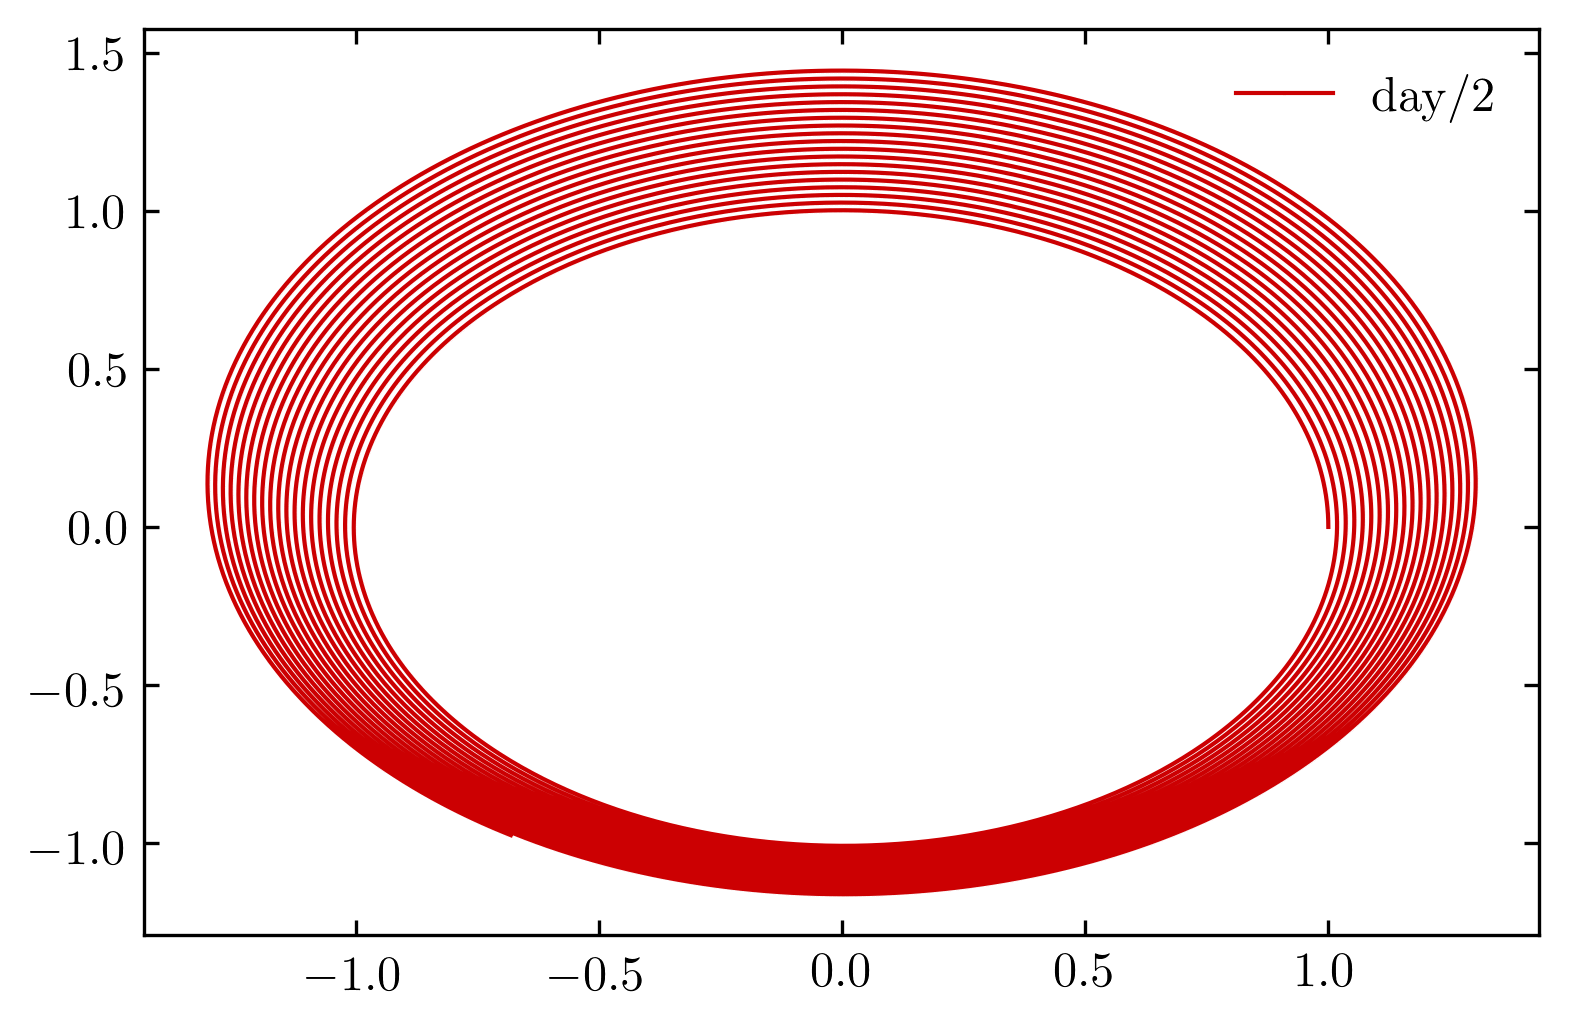

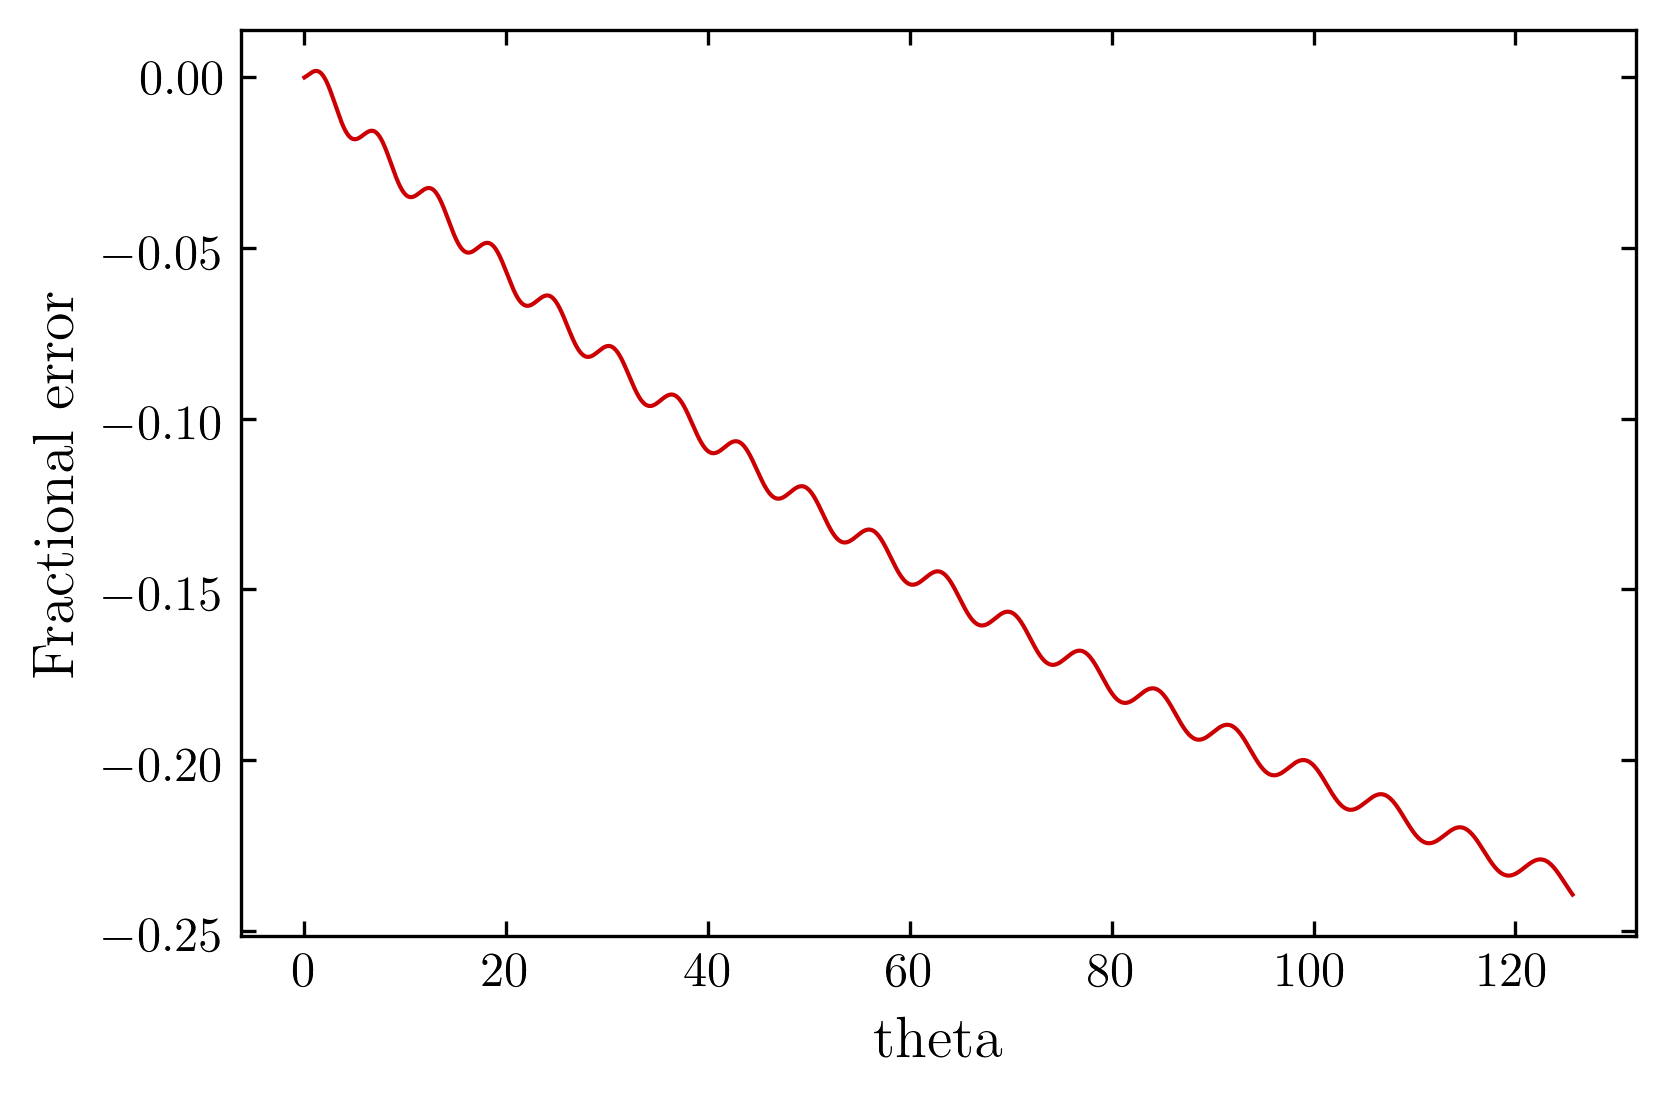

In [73]:
sim = integrator()
sim.add_obj((1, 0, 0, 0, 0))
sim.add_obj((1e-3, 1, 0, 0, 1))
end = 20 * 2*np.pi
_, ax = plt.subplots()
_, ax2 = plt.subplots()

for (step, lab) in [(day/2, "day/2")]:
    results = sim.runge_kutta_4_integrate(end, step)
    ax.plot(results[:,1]["x"], results[:,1]["y"], marker=".", markersize=0.02, label=lab)
    
    energy = np.sum(0.5 * results["mass"] * (results["vx"]**2 + results["vy"]**2), axis=1)
    ax2.plot(np.linspace(0, end, len(energy)), (energy - energy[0]) / energy[0])
ax.legend()
ax2.legend()
ax2.set(ylabel="Fractional error", xlabel="theta")